In [1]:
%matplotlib inline
import os
import json
import pickle
from itertools import islice
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
sec_in_hour = 60 * 60
sec_in_day = sec_in_hour * 24

# database is created using https://github.com/hermit-crab/discord-export
# for any other type of chat / log you'll need to first cell inside Data loading section below
dbfiles = ['/home/archibald/chat.jl']

dbcache = f'/tmp/_dbcache.p'
default_saveimage_to = '/tmp/fig.png'

### Data loading

In [3]:
def snowflake_to_ts(snowflake):
    return ((int(snowflake) >> 22) + 1420070400000) / 1000

def load_data():
    for file in dbfiles:
        fields = 'timestamp author'.split()
        with open(file) as f:
            for l in f:
                if l.startswith('{"type":"message"'):
                    data = json.loads(l)['data']
                    yield {
                        'Author': data['author']['id'],
                        'Author_Name': data['author']['username'],
                        'Timestamp': snowflake_to_ts(data['id'])
                    }

try:
    with open(dbcache, 'rb') as f:
        df = pickle.load(f)
except FileNotFoundError:
    df = pd.DataFrame.from_records(load_data())
    df = df.assign(Timestamp=pd.to_datetime(df.Timestamp, unit='s')).set_index('Timestamp').sort_index()
    with open(dbcache, 'wb') as f:
        pickle.dump(df, f)

df_main = df

### Utilities

In [5]:
def d2n(dates, tz=None):
    dates = pd.to_datetime(dates)
    arr = np.atleast_1d(dates)
    if len(arr) and isinstance(arr[0], str):
        is_single = not isinstance(dates, (list, tuple, np.ndarray))
        if tz:
            dates = dates.tz_localize(tz)
        if is_single:
            dates = dates[0]
    elif len(arr) and tz:
        raise ValueError('tz argument only allowed for string dates')

    return mpl.dates.date2num(dates)

def dates_to_days_seconds(dates):
    nums = d2n(dates)
    days = nums.astype(int)
    return np.asarray([days, nums % days * sec_in_day])

def shift_contain(dates):
    # find hour offset that makes activity best centered inside a day
    # not very efficient but does the trick
    stats = []
    for i in range(-12, 13):
        shifted = pd.Series(dates + pd.DateOffset(hours=i))
        a = shifted.dt.hour.quantile(.03)
        b = 24 - shifted.dt.hour.quantile(.97)
        stats.append((a + b) - abs(a - b))
    best = -12+int(np.argmax(stats))
    return dates + pd.DateOffset(hours=best)

def incl_arange(start, stop, step):
    # arange that always includes the stop
    x = np.arange(start, stop+1, step)
    if x[-1] != stop:
        x = np.append(x, [stop])
    return x

### Density calculation

In [6]:
from scipy.stats import multivariate_normal
from statsmodels.nonparametric.kernel_density import gpke

# bivariate "days over seconds of day" events density (unnormalized)

def day_density(dates, xlim, ylim, grid_step=(5, 60*30),
            method='gpke', bw=(6, sec_in_hour*1.4),
            delta_cut=(25, sec_in_hour*5)):

    xruler = incl_arange(*xlim, grid_step[0])
    yruler = incl_arange(*ylim, grid_step[1])
    XX, YY = np.meshgrid(xruler, yruler)

    days_seconds = dates_to_days_seconds(dates)
    d, s = days_seconds
    
    # append 1 day shifted events to the top and bottom of the data
    # so that kde sees the day continuity
    wrapping = np.vstack([np.append(d+1, d-1), np.append(s-sec_in_day, s+sec_in_day)])
    wrapped = np.hstack([days_seconds, wrapping])

    cov = ((bw[0]**2, 0), (0, bw[1]**2)) # for scipy

    Z = []
    xd, yd = delta_cut
    ds = wrapped.T
    for n, (x, y) in enumerate(zip(XX.ravel(), YY.ravel())):
        train_data = ds[np.logical_and(np.abs(ds[:, 0] - x) <= xd, np.abs(ds[:, 1] - y) <= yd)]
        if method == 'gpke':
            dens = gpke(np.asarray(bw), train_data, np.asarray([x, y]), 'cc')
        elif method == 'scipy':
            dens = multivariate_normal([x, y], cov).pdf(train_data).sum()

        Z.append(dens)

        if n % 100 == 0:
            print(f'\revaluating: {n/XX.size:.3f}', end='')
    print()
    
    return XX, YY, np.asarray(Z).reshape(XX.shape)

### Cache functionality for heavy operations

In [7]:
def cached_on_args(key, fn, *args, **kw):
    key = key + json.dumps(args) + json.dumps(kw, sort_keys=True)
    if key in fn_cache:
        return fn_cache[key]
    else:
        ret = fn(*args, **kw)
        fn_cache[key] = ret
        return ret

In [9]:
fn_cache = {}

### Plot decor

In [10]:
from contextlib import contextmanager
import subprocess

@contextmanager
def dark():
    style = {
        'xtick.color': '#ffffffb2',
        'ytick.color': '#ffffffb2',
        'text.color': '#ffffffb2',
        'axes.labelcolor': '#ffffffb2',
        'figure.facecolor': '#36393E',
        'axes.facecolor': '#000006'
    }
    stash = {k: mpl.rcParams[k] for k in style.keys()}
    mpl.rcParams.update(style)
    try:
        yield
    finally:
        mpl.rcParams.update(stash)

def to_image(filename=None, **kw):
    filename = filename or default_saveimage_to
    kw = {'facecolor': plt.gcf().get_facecolor(), 'bbox_inches': 'tight', **kw}
    plt.savefig(filename, **kw)
    plt.close('all')
    subprocess.run(['xdg-open', filename])

def date_fmt(dt, i):
    dt = mpl.dates.num2date(dt)
    if dt.month == 1 or i == 0:
        return dt.strftime('%b\n%Y')
    else:
        return dt.strftime('%b')

def axes_decor(axes):
    for ax in axes:
        ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(date_fmt))
        ax.xaxis.set_minor_locator(mpl.dates.YearLocator())
        ax.tick_params(which='both', left=None, labelleft=None, bottom=None)
        plt.setp(ax.get_xmajorticklabels(), linespacing=1.4)
        ax.grid(True, axis='x', which='major', color='w', alpha=.1, linewidth=.5)
        ax.grid(True, axis='x', which='minor', color='w', alpha=.5, linewidth=.5)
        plt.setp(ax.spines.values(), visible=False)

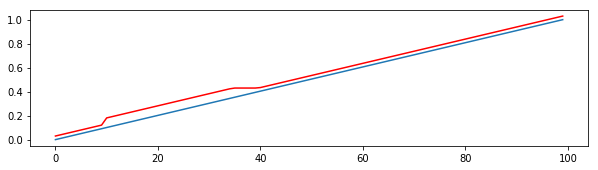

In [55]:
# this normalizer will brighten/darken a segment of color range

class CustomNormilizer(mpl.colors.Normalize):
    def __init__(self, start, stop, bump, *args, **kw):
        self.start = start
        self.stop = stop 
        self.bump = bump
        super().__init__(*args, **kw)

    def __call__(self, value, clip=None):
        normed = super().__call__(value)
        cond = np.logical_and(normed > self.start, normed < self.stop)
        normed[cond] += self.bump
        normed[cond] = normed[cond].clip(self.start, self.stop)
        return normed

# preview of its workings
plt.figure(figsize=(10, 2.5))
vals = np.linspace(0, 1, 100)
plt.plot(vals)
norm = CustomNormilizer(.1, .4, .05)
norm.autoscale(vals)
plt.plot(norm(vals) + .03, color='r')
plt.show()

### Main

In [524]:
# which people to plot (name, database id's associated)
of_interest = [
('Peter', ('164897508013596240',)),
('Andrew', ('166969151281811456',)),
('James', ('182427469985349632', '185289705829564416')),
('John', ('142422516565446968',)),
]

==> calculating Peter
==> calculating Andrew
==> calculating James
==> calculating John
==> 99% density level: 0.008272951891109576
==> max density level: 0.013018006659302842
==> plotting Peter
==> plotting Andrew
==> plotting James
==> plotting John
==> overall activity plot
done


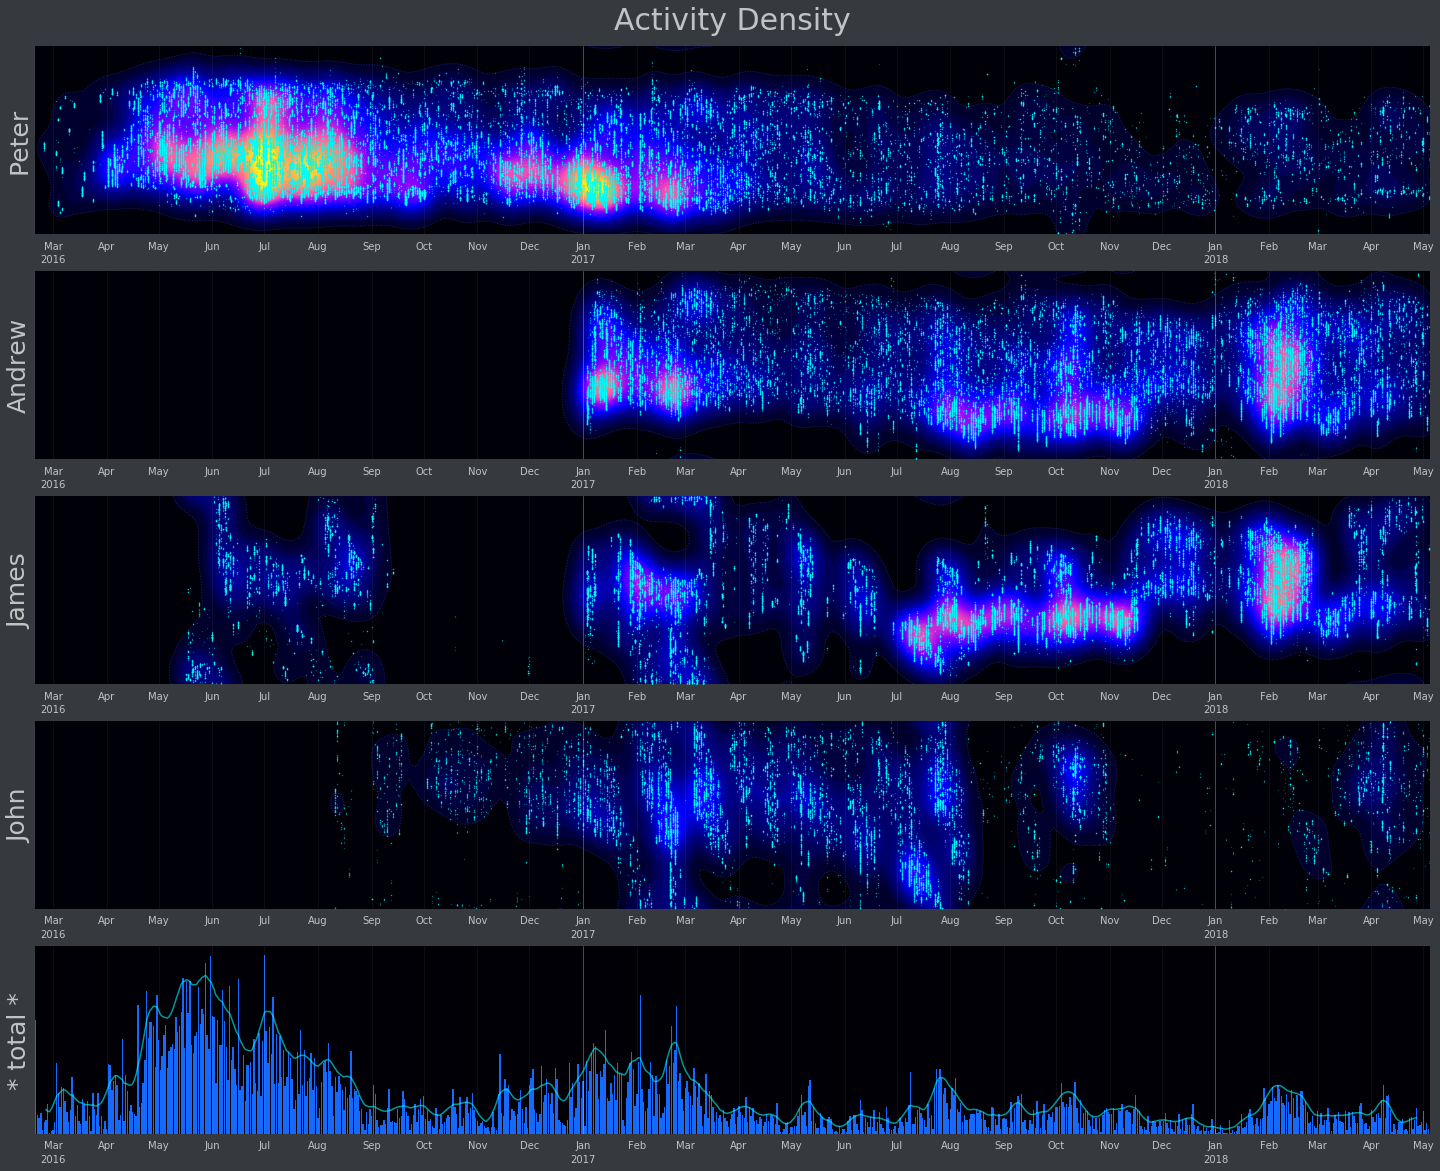

In [527]:
# main plot config 
#########################

density_args = dict(
    grid_step=(4, 60*30),
    method='gpke', bw=(7, sec_in_hour*1.8),
    delta_cut=(25, sec_in_hour*5)
)
ref_top_level = 0.01381 # hand picked reference level, see output of this cell
levels = np.linspace(0, ref_top_level, 50)
contour_args = dict(levels=levels[:2], colors='w', alpha=.12, linestyles='dotted', linewidths=1)
norm = CustomNormilizer(.015, .12, .015) # we want to brighten low activity levels a little bit
contourf_args = dict(cmap='gnuplot2', levels=levels, norm=norm, extend='max')
scatter_args = dict(s=.1, alpha=.4, color='cyan')
tz = 'best_fit' # timezone, None or 'best_fit'
# tz = 'Europe/Vienna'

date_start = df.index[0]
date_stop = df.index[-1]
# date_start, date_stop = '2016 May', '2016 November'

# dataframes to plot

# per user
df_split = [(name, df_main[df_main.Author.isin(ids)][date_start:date_stop]) for name, ids in of_interest]
# add all who was ignored as a one user
# included_ids = [id for _, ids in of_interest for id in ids]
# subframes.append(('* rest *', df_main[~df_main.Author.isin(included_ids)]))

# there goes the thing
#########################

xlim = list(d2n((date_start, date_stop)))
ylim = (0, sec_in_day)

def calcall():
    precalc = {}
    for name, df in df_split:
        print('==> calculating', name)
        cache_key = f'kk{name}{tz}{xlim}'
        dates = df.index
        if tz == 'best_fit':
            dates = cached_on_args(cache_key, partial(shift_contain, dates))
        elif tz is not None:
            dates = dates.tz_localize('UTC').tz_convert(tz).tz_localize(None)
        precalc[name] = {
            'dates': dates,
            'density': cached_on_args(cache_key, partial(day_density, dates), xlim, ylim, **density_args)
        }
    return precalc

def plotall(calced):
    nrows = len(df_split) + 1
    fig, axes = plt.subplots(nrows, 1, figsize=(25, 4*nrows))
    axes = list(np.atleast_1d(axes))
    axes_iter = iter(axes)

    axes[0].set_title('Activity Density', size=30, pad=17)
        
    for name, df in df_split:
        print('==> plotting', name)
        ax = next(axes_iter)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        data = calced[name]
        (X, Y, Z), dates = data['density'], data['dates']
        if contourf_args is not None:
            ax.contourf(X, Y, Z, **contourf_args)
        if contour_args is not None:
            ax.contour(X, Y, Z, **contour_args)
        if scatter_args is not None:
            ax.scatter(*dates_to_days_seconds(dates), **scatter_args)
        ax.set_ylabel(name, size=25)
        ax.invert_yaxis()

    print('==> overall activity plot')
    
    hist = df_main.resample('1D').Author.count()
    avg = hist.rolling(15, win_type='triang').mean().shift(-7, 'D') * 1.3
    hist = hist[date_start:date_stop]
    avg = avg[date_start:date_stop]
    
    ax = next(axes_iter)
    ax.bar(d2n(hist.index), hist, color='#1569FD')
    ax.plot(d2n(avg.index), avg, alpha=.6, color='cyan')
    ax.set_xlim(xlim)
    ax.set_ylabel('* total *', size=25)
    ax.set_ylim(0, ax.get_ylim()[1])
    
    axes_decor(axes)
    print('done')

def plot_levels_info(levels):
    unique = np.unique(levels)

    plt.figure(figsize=(16, 4))

    plt.subplot(221)
    plt.plot(unique, 'o', alpha=.05, ms=2)
    plt.xticks(rotation=30)
    plt.tick_params(bottom=False, labelbottom=False)
    plt.title('unique activity levels')

    plt.subplot(222)
    plt.semilogy(unique, 'o', alpha=.05, ms=2)
    plt.xticks(rotation=30)
    plt.tick_params(bottom=False, labelbottom=False)
    plt.title('unique activity levels, log scale')

    plt.subplot(223)
    _, bins, _ = plt.hist(levels)
    plt.xticks(bins, rotation=30)
    plt.title('activity levels hist')

    plt.subplot(224)
    _, bins, _ = plt.hist(levels, log=True)
    plt.xticks(bins, rotation=30)
    plt.ticklabel_format()
    plt.title('activity levels hist, log scale')

    plt.subplots_adjust(wspace=.1, hspace=.3)
    plt.show()

if False:
    calced = calcall()

    levels = np.sort(np.concatenate([u['density'][2].ravel() for u in calced.values()]))
    print('==> 99% density level:', np.percentile(levels, 99))
    print('==> max density level:', levels.max())
#     plot_levels_info(levels)

    with dark():
        plotall(calced)
#         to_image(pad_inches=.2)
        plt.show()